In [1]:
import wmfdata
spark = wmfdata.spark.get_session(type='yarn-regular')

You are using wmfdata v1.3.2, but v1.3.3 is available.

To update, run `pip install --upgrade git+https://github.com/wikimedia/wmfdata-python.git@release --ignore-installed`.

To see the changes, refer to https://github.com/wikimedia/wmfdata-python/blob/release/CHANGELOG.md
PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


In [2]:
#using revs from 2021-10, because the wikidata-iu is already implemented
revs  = spark.sql('''SELECT page_namespace, revision_tags
            FROM wmf.mediawiki_history WHERE event_entity = 'revision'  
            AND wiki_db = 'wikidatawiki' AND snapshot = '2021-11'  AND
            TO_TIMESTAMP(event_timestamp) BETWEEN TO_TIMESTAMP("2021-10-01") AND TO_TIMESTAMP("2021-11-01")
            AND SIZE(event_user_is_bot_by) = 0 ''')
from pyspark.sql.functions import explode

revs_tags = revs.select( 'page_namespace',explode(revs.revision_tags))
revs_ui = revs_tags.where(revs_tags['col'] == 'wikidata-ui')

In [ ]:
namespaces_wikidata = revs_ui.groupby('page_namespace').count().toPandas()

In [ ]:
namespaces_wikidata #weird, maybe the wikidata-ui tag is not present in other namespaces

In [ ]:
namespaces_wikidata_without_filter = spark.sql('''SELECT page_namespace, COUNT(*)
            FROM wmf.mediawiki_history WHERE event_entity = 'revision'
            AND wiki_db = 'wikidatawiki' AND snapshot = '2021-11'  AND
            TO_TIMESTAMP(event_timestamp) BETWEEN TO_TIMESTAMP("2021-10-01") AND TO_TIMESTAMP("2021-11-01")
            AND SIZE(event_user_is_bot_by) = 0
            GROUP BY page_namespace''').toPandas()

In [ ]:
namespaces_wikidata_without_filter['ratio'] = 100* namespaces_wikidata_without_filter['count(1)'] / namespaces_wikidata_without_filter['count(1)'].sum()
namespaces_wikidata_without_filter.sort_values('page_namespace')

In [44]:
#if we consider that all the page namespace = 1 are done manually the ratio of manual edits 
# mixing the wikidata-ui with the pagename 
100 * 1347 /  1745989

0.0771482523658511

In [ ]:
namespaces_enwiki = spark.sql('''SELECT page_namespace, COUNT(*)
            FROM wmf.mediawiki_history WHERE event_entity = 'revision'
            AND wiki_db = 'enwiki' AND snapshot = '2021-11'  AND
            TO_TIMESTAMP(event_timestamp) BETWEEN TO_TIMESTAMP("2021-10-01") AND TO_TIMESTAMP("2021-11-01")
            AND SIZE(event_user_is_bot_by) = 0
            GROUP BY page_namespace''').toPandas()

In [13]:
namespaces_enwiki['ratio'] = 100* namespaces_enwiki['count(1)'] / namespaces_enwiki['count(1)'].sum()
namespaces_enwiki.sort_values('page_namespace')

page_namespace  count(1)      ratio
16             0.0   2646293  70.825353
22             1.0    288658   7.725639
19             2.0    239012   6.396914
3              3.0    184176   4.929284
8              4.0    125641   3.362654
18             5.0     16018   0.428706
24             6.0     21026   0.562740
0              7.0      4315   0.115487
17             8.0       106   0.002837
4              9.0       472   0.012633
2             10.0     67934   1.818185
15            11.0      5343   0.143000
20            12.0       531   0.014212
9             13.0       454   0.012151
14            14.0     35321   0.945331
11            15.0      8278   0.221552
21           100.0      3870   0.103577
7            101.0       108   0.002891
12           118.0     79337   2.123374
6            119.0      5067   0.135613
10           710.0        41   0.001097
1            711.0         2   0.000054
23           828.0      3870   0.103577
13           829.0       259   0.006932
5              NaN       232   0.006209

In [43]:
100 * 288658/2646293

10.908013587308737

In [4]:
namespaces_allwikis = spark.sql('''SELECT page_namespace, wiki_db, COUNT(*) as cnt
            FROM wmf.mediawiki_history WHERE event_entity = 'revision'
             AND snapshot = '2021-11'  AND
            TO_TIMESTAMP(event_timestamp) BETWEEN TO_TIMESTAMP("2021-10-01") AND TO_TIMESTAMP("2021-11-01")
            AND SIZE(event_user_is_bot_by) = 0
            GROUP BY page_namespace, wiki_db''').toPandas()

In [5]:
namespaces_allwikis_dict = {}
for wiki,data in namespaces_allwikis.groupby('wiki_db'):
    if data['cnt'].sum() > 1000: #considering projects with more than 100 edits
        try:
            talk_tmp = data[data['page_namespace'] == 1]['cnt'].tolist()[0]
        except: 
            talk_tmp = 0
        try:
            talk_user = data[data['page_namespace'] == 3]['cnt'].tolist()[0]
        except: 
            talk_user = 0
        try:
            project = data[data['page_namespace'] == 4]['cnt'].tolist()[0]
        except: 
            project = 0
        try:
            project_talk = data[data['page_namespace'] == 5]['cnt'].tolist()[0]
        except: 
            project_talk = 0
        article_tmp = data[data['page_namespace'] == 0]['cnt'].tolist()[0]
        namespaces_allwikis_dict[wiki] = [talk_tmp/article_tmp, talk_tmp+article_tmp,
                                          talk_user/article_tmp,project / article_tmp,
                                         project_talk/article_tmp]
        

In [6]:
import pandas as pd
namespaces_allwikis_df = pd.DataFrame(namespaces_allwikis_dict).T

In [7]:
namespaces_allwikis_df.rename(columns={0:'talk_ratio',1:'pages_edited',2:'talk_user',
                                      3:'project',4:'project_talk'},inplace=True)

<AxesSubplot:xlabel='1', ylabel='0'>

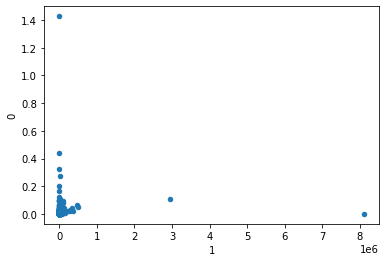

In [92]:
namespaces_allwikis_df.plot.scatter(x=1,y=0)

<AxesSubplot:>

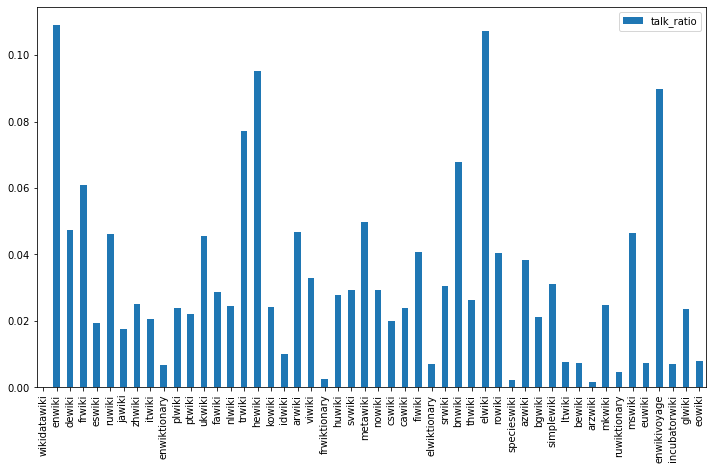

In [8]:
namespaces_allwikis_df.sort_values('pages_edited',ascending=False)[0:50].plot.bar(y='talk_ratio',figsize=(12,7))

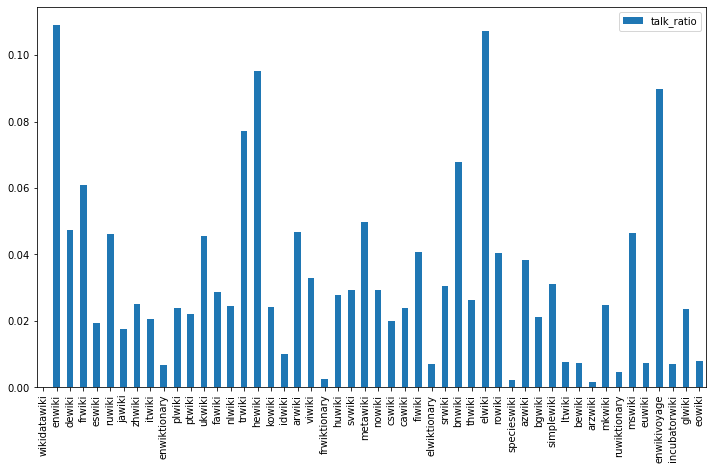

In [14]:
namespaces_allwikis_df.sort_values('pages_edited',ascending=False)[0:50].plot.bar(y='talk_ratio',figsize=(12,7)).get_figure().savefig('talk_pages_ratio.png')

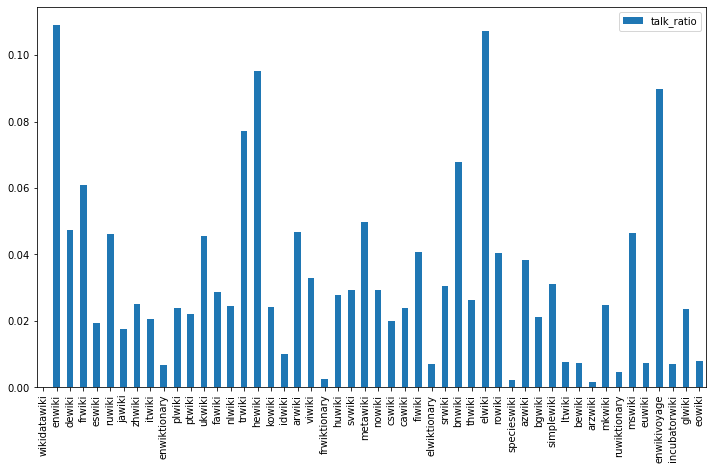

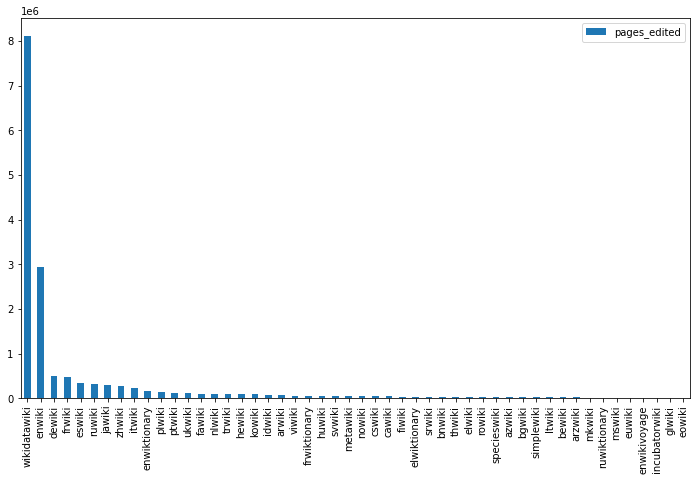

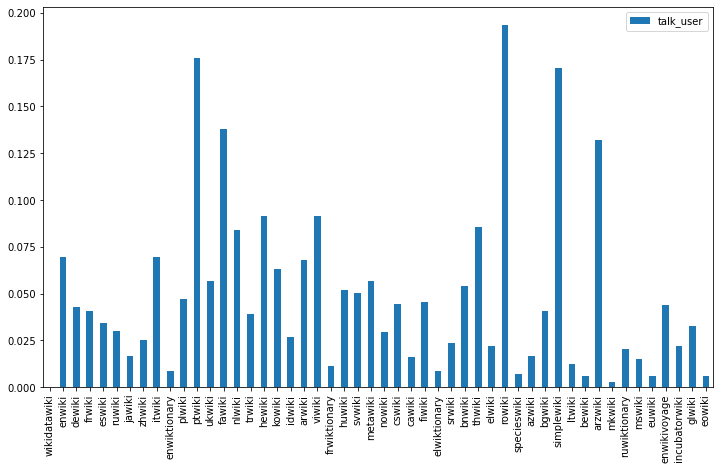

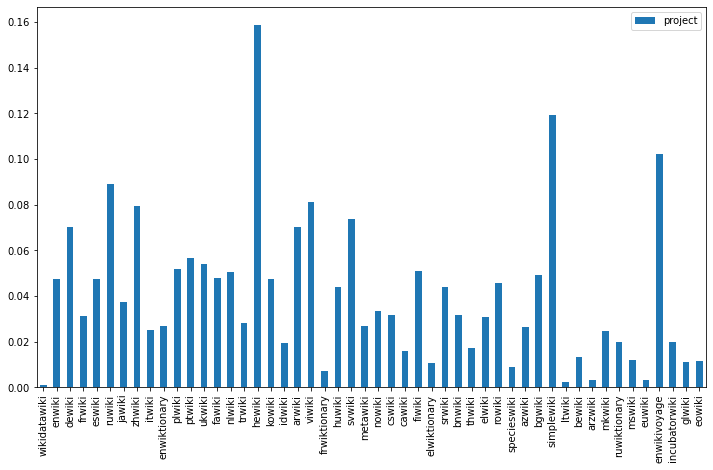

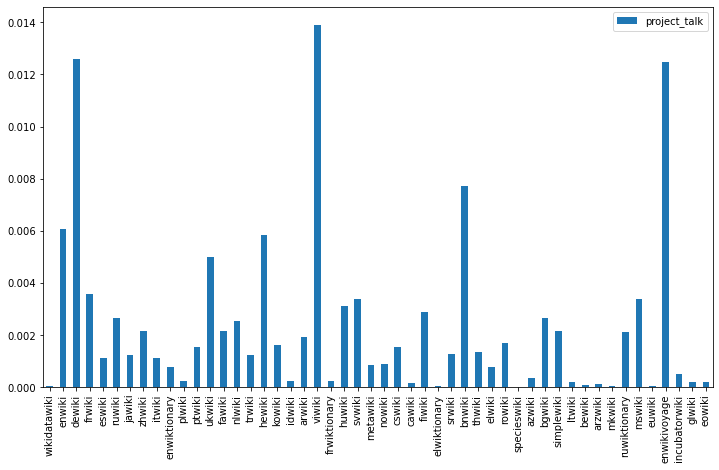

In [11]:
for c in namespaces_allwikis_df.columns:
    p = namespaces_allwikis_df.sort_values('pages_edited',ascending=False)[0:50].plot.bar(y=c,figsize=(12,7))